In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import os, sys
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import gpytorch
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error

import rdkit
import rdkit.Chem as chem
import rdkit.Chem.AllChem as allchem

from ngboost import NGBRegressor

from mordred import Calculator, descriptors

from molar_interface import MolarInterface

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Make connection to the MolarDB 

In [24]:
# define user details
user_details = {
    'email':'riley.hickman13@gmail.com',
    'password':'az1$jH5v',
}


In [25]:
db = MolarInterface(user_details, database_name='organizer_laser') # client in client attribute
db.client.test_token()

{'email': 'riley.hickman13@gmail.com',
 'is_superuser': False,
 'is_active': True,
 'full_name': 'rileyhickman',
 'created_on': '2022-01-18T19:16:33.241173',
 'user_id': 3}

## Retrieve the first set of molecules in the DB

We use a filtered query to return all of the molecules for which we have tried to measure the optical properties. 

40 syntheses tested in total (33 success, 7 failed)


properties listed include: 

* tau1 
* tau2 
* abs_end
* abs_max
* max_gain_wl
* relative_QY
* PL_lambda_max
* abs_lambda_max
* max_gain_factor
* PL_max_intensity 
* validation_status (bool)
* gain_cross_section 
* PL_degradation_rate
* abs_degradation_rate


The entire set of available C frags constitutes 133 structures, 40 of which have already been tested in the first round, therefore, there should be 93 heldout structures to chose form for the next round

We will pick a batch of 40


In [26]:
# custom query to get the molecules with the optical properties
df = db.client.query_database(
    [
      'machine',
      'lab',
      'synthesis',
      'molecule',
      'molecule_molecule',
      'molecule.optical_properties',
    ],
    joins = [
      {
        'type': 'molecule',
        'on': {
          'column1': 'molecule.molecule_id',
          'column2': 'synthesis.molecule_id',
            
        },
      },
      {
        'type': 'molecule_molecule',
        'on': {
          'column1': 'molecule_molecule.molecule_id',
          'column2': 'molecule.molecule_id',
        },
      },
      {
        'type': 'machine',
        'on': {
          'column1': 'machine.machine_id',
          'column2': 'synthesis.machine_id',
        },
      },
      {
        'type': 'lab',
        'on': {
          'column1': 'lab.lab_id',
          'column2': 'synthesis.lab_id',
        },
      },
    ],
limit=1000)

In [27]:
print(df.shape)
print(df['synthesis.status'].value_counts())
df.head()

(40, 31)
DONE      33
FAILED     7
Name: synthesis.status, dtype: int64


,machine.machine_id,machine.created_on,machine.updated_on,machine.name,machine.lab_id,lab.lab_id,lab.created_on,lab.updated_on,lab.name,synthesis.synthesis_id,...,molecule.optical_properties,molecule.commercially_available,molecule.molecule_type_id,molecule_molecule.molecule_molecule_id,molecule_molecule.created_on,molecule_molecule.updated_on,molecule_molecule.fragment_a,molecule_molecule.fragment_b,molecule_molecule.fragment_c,molecule_molecule.molecule_id
0,5d75e30a-2508-4ec0-8cb7-5b4519ebe53a,2022-07-15T18:28:09.435840,2022-07-15T18:28:09.435840,ChemSpeed,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,2022-07-15T18:28:09.091567,2022-07-15T18:28:09.091567,Toronto,78a4835c-a444-4b43-a4a7-42fb16959d12,...,"{'tau1': 1.167852587304393, 'tau2': None, 'abs...",False,a2fa8475-792e-4fea-930d-eb72d0f99fda,99c364fd-c0f8-4038-8c9c-14369d85740e,2022-07-24T14:20:49.997926,2022-07-24T14:20:49.997926,b559be9f-d69b-40e1-b6e7-8400b1209bf9,a5aee53d-425c-490d-9ed4-38118acb5eba,5631d850-f818-4905-8672-bfbc7db094c6,0bbc1f80-dda1-4b8f-9f99-6e9326ee70fb
1,5d75e30a-2508-4ec0-8cb7-5b4519ebe53a,2022-07-15T18:28:09.435840,2022-07-15T18:28:09.435840,ChemSpeed,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,2022-07-15T18:28:09.091567,2022-07-15T18:28:09.091567,Toronto,41b37ad8-66e2-4635-9682-1a6651837b29,...,"{'tau1': 1.326106010239319, 'tau2': None, 'abs...",False,a2fa8475-792e-4fea-930d-eb72d0f99fda,4e0be5b8-5855-4435-ba50-6b573a381aca,2022-07-24T14:34:48.864338,2022-07-24T14:34:48.864338,b559be9f-d69b-40e1-b6e7-8400b1209bf9,a5aee53d-425c-490d-9ed4-38118acb5eba,206358a4-3e4e-4381-ab4f-9b061171ba37,dbd8d42a-d462-4a00-92e6-fa0a79bc583c
2,5d75e30a-2508-4ec0-8cb7-5b4519ebe53a,2022-07-15T18:28:09.435840,2022-07-15T18:28:09.435840,ChemSpeed,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,2022-07-15T18:28:09.091567,2022-07-15T18:28:09.091567,Toronto,4c111a7d-d086-44d6-8406-ca6d7ffbfaa6,...,"{'tau1': 1.2432569989842444, 'tau2': None, 'ab...",False,a2fa8475-792e-4fea-930d-eb72d0f99fda,8e87a647-a56d-4fa0-89f1-a1a8532b5216,2022-07-24T14:34:58.914180,2022-07-24T14:34:58.914180,b559be9f-d69b-40e1-b6e7-8400b1209bf9,a5aee53d-425c-490d-9ed4-38118acb5eba,1e7bac53-a45a-4ab3-8a25-b3835a3b4c38,ce8505b9-7bd5-4ea1-9d90-bd2d8f0cb493
3,5d75e30a-2508-4ec0-8cb7-5b4519ebe53a,2022-07-15T18:28:09.435840,2022-07-15T18:28:09.435840,ChemSpeed,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,2022-07-15T18:28:09.091567,2022-07-15T18:28:09.091567,Toronto,77886175-2a6d-40c2-bce4-f5aecb305a13,...,"{'tau1': 2.6058556280711582, 'tau2': None, 'ab...",False,a2fa8475-792e-4fea-930d-eb72d0f99fda,f1655c2a-6c6d-44e0-b8e1-589f5256ce60,2022-07-24T14:35:08.655682,2022-07-24T14:35:08.655682,b559be9f-d69b-40e1-b6e7-8400b1209bf9,a5aee53d-425c-490d-9ed4-38118acb5eba,c63f45da-0d55-4999-abec-9224c644ad27,3df2f8bf-9489-43b0-a701-43132e7ad7e1
4,5d75e30a-2508-4ec0-8cb7-5b4519ebe53a,2022-07-15T18:28:09.435840,2022-07-15T18:28:09.435840,ChemSpeed,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,2022-07-15T18:28:09.091567,2022-07-15T18:28:09.091567,Toronto,8ef90bde-659e-4703-b8f7-bbc2f9922227,...,"{'tau1': 1.3049378623534678, 'tau2': 4.7068837...",False,a2fa8475-792e-4fea-930d-eb72d0f99fda,69a92ac6-2cea-440d-ace4-8a904ca8182b,2022-07-24T14:35:49.300613,2022-07-24T14:35:49.300613,b559be9f-d69b-40e1-b6e7-8400b1209bf9,a5aee53d-425c-490d-9ed4-38118acb5eba,c426c95f-4eeb-4b89-bff7-46001aea9ee7,9fea8c04-5fa4-4b05-bdd2-e01600ac0d30


In [7]:
target = 'gain_cross_section'
frag_a_smiles, frag_b_smiles, frag_c_smiles = [], [], []
targets = []
failed_frag_c_smiles = []

for _, row in df.iterrows():
    row = row.to_dict()
    frag_a_details = db.get_fragment_details(
        row['molecule_molecule.fragment_a'], identifier_type='molecule_id'
    )
    frag_b_details = db.get_fragment_details(
        row['molecule_molecule.fragment_b'], identifier_type='molecule_id'
    )
    frag_c_details = db.get_fragment_details(
        row['molecule_molecule.fragment_c'], identifier_type='molecule_id'
    )
    props = row['molecule.optical_properties']
    try:
        targets.append(props[target])
        frag_a_smiles.append(frag_a_details['smiles'])
        frag_b_smiles.append(frag_b_details['smiles'])
        frag_c_smiles.append(frag_c_details['smiles'])

    except:
        failed_frag_c_smiles.append(frag_c_details['smiles'])
      
        

In [8]:
print(len(frag_a_smiles), len(frag_b_smiles), len(frag_c_smiles))
print(len(targets))
print(len(failed_frag_c_smiles))

33 33 33
33
7


## Get available (unmeasured) C frags

In [9]:
frag_df = db.get_lab_avail_frags(lab='Toronto', available=True)
print(frag_df.shape)
print(frag_df['molecule.molecule_type_id'].unique())
# C frag id = '6bfdedaf-6977-47a7-bbab-fe232f7626b8'
frag_df.head()

(135, 12)
['9fe968ae-7627-4862-b08d-8f28245538ef'
 'f9a2b546-d308-404c-846d-de52f96cb615'
 '6bfdedaf-6977-47a7-bbab-fe232f7626b8']


,lab_molecule.lab_molecule_id,lab_molecule.updated_on,lab_molecule.available,lab_molecule.lab_id,lab_molecule.molecule_id,lab.lab_id,lab.name,molecule.molecule_id,molecule.hid,molecule.smiles,molecule.commercially_available,molecule.molecule_type_id
0,e558d3a1-cc48-4349-a0dd-f582f4a1dac1,2022-07-15T18:28:10.343041,True,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,b559be9f-d69b-40e1-b6e7-8400b1209bf9,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,Toronto,b559be9f-d69b-40e1-b6e7-8400b1209bf9,A001,CC1(C)OB(c2ccc(-n3c4ccccc4c4ccccc43)cc2)OC1(C)C,True,9fe968ae-7627-4862-b08d-8f28245538ef
1,e8eb31d9-6130-4554-8425-dd0649743379,2022-07-15T18:28:10.596874,True,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,a5aee53d-425c-490d-9ed4-38118acb5eba,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,Toronto,a5aee53d-425c-490d-9ed4-38118acb5eba,B003,C[N+]12CC(=O)O[B-]1(/C=C/Br)OC(=O)C2,True,f9a2b546-d308-404c-846d-de52f96cb615
2,a595d2d2-92bf-4019-ad3f-54b228117e3d,2022-07-15T18:28:10.853945,True,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,5631d850-f818-4905-8672-bfbc7db094c6,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,Toronto,5631d850-f818-4905-8672-bfbc7db094c6,C001,Brc1ccc(-c2ccc(Br)cc2)cc1,True,6bfdedaf-6977-47a7-bbab-fe232f7626b8
3,1b33304a-bc1d-411d-b327-27636375ff7b,2022-07-15T18:28:11.166084,True,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,206358a4-3e4e-4381-ab4f-9b061171ba37,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,Toronto,206358a4-3e4e-4381-ab4f-9b061171ba37,C002,Ic1ccc(I)cc1,True,6bfdedaf-6977-47a7-bbab-fe232f7626b8
4,fb03aac4-d1a0-42a5-b9b1-bb908c948d49,2022-07-15T18:28:11.433845,True,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,1e7bac53-a45a-4ab3-8a25-b3835a3b4c38,8c71baef-6ffe-428e-b343-7bcd7f65a3e1,Toronto,1e7bac53-a45a-4ab3-8a25-b3835a3b4c38,C003,Cc1cc(Br)c(C)cc1Br,True,6bfdedaf-6977-47a7-bbab-fe232f7626b8


In [10]:
frag_df = frag_df[frag_df['molecule.molecule_type_id']=='6bfdedaf-6977-47a7-bbab-fe232f7626b8']
print(frag_df.shape)

(133, 12)


In [11]:
# get the smiles of all the C fragments
all_frag_c_smiles = []

for _, row in frag_df.iterrows():
    row = row.to_dict()
    frag_c_details = db.get_fragment_details(
        row['molecule.molecule_id'], identifier_type='molecule_id'
    )
    all_frag_c_smiles.append(frag_c_details['smiles'])


In [12]:
# get unmeasured c fragments
unmeas_frag_c_smiles = list(set(all_frag_c_smiles) - set(frag_c_smiles+failed_frag_c_smiles))

In [13]:
print(len(all_frag_c_smiles))
len(unmeas_frag_c_smiles)

133


93

## Generate Mordred descriptors for all the cores

In [14]:
def replace_halides(smiles):
    rep_smiles = []
    for smi in smiles:
        if 'I' in smi:
            mod_mol = chem.ReplaceSubstructs(
                    chem.MolFromSmiles(smi),
                    chem.MolFromSmiles('I'),
                    chem.MolFromSmiles('C=C'),
                    replaceAll=True,
                )[0]
        elif 'Br' in smi:
            mod_mol = chem.ReplaceSubstructs(
                    chem.MolFromSmiles(smi),
                    chem.MolFromSmiles('Br'),
                    chem.MolFromSmiles('C=C'),
                    replaceAll=True,
                )[0]
        else:
            raise ValueError
        
        rep_smiles.append(chem.MolToCXSmiles(mod_mol))
        
    return rep_smiles
                

In [15]:
# replace the halide atoms with C=C
frag_c_smiles_rep = replace_halides(frag_c_smiles)
unmeas_frag_c_smiles_rep = replace_halides(unmeas_frag_c_smiles)

# tmp so we know the indices (training set :33, test set 33:)
c_smiles = frag_c_smiles_rep+unmeas_frag_c_smiles_rep
c_mols = [chem.MolFromSmiles(s) for s in c_smiles]

In [16]:
# compute mordred descriptors
calc = Calculator(descriptors, ignore_3D=True)
print('num desc :', len(calc.descriptors))

df_mord_tmp = calc.pandas(c_mols)

num desc : 1613


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:05<00:00, 24.85it/s]


In [17]:
# remove inconpatible data types
print('>>> removing incompatible data types...')
df_mord_tmp = df_mord_tmp.select_dtypes(exclude=['O', 'bool'])

print(df_mord_tmp.shape)

# remove descriptors that have zero variance over all fragments
print('>>> removing descriptors with zero variance...')
num_unique = df_mord_tmp.apply(pd.Series.nunique)
df_mord_tmp = df_mord_tmp.drop(num_unique[num_unique==1].index, axis=1)

print(df_mord_tmp.shape)

# add back the smiles and mol cols
df_mord_tmp['smiles'] = c_smiles
df_mord_tmp['mols'] = c_mols


>>> removing incompatible data types...
(126, 1350)
>>> removing descriptors with zero variance...
(126, 1141)


## PCA analysis on fragment descriptors

In [18]:
def make_pca_analysis(df, num_components=100, skipcols=3):
    
    X  = df.iloc[:, :-skipcols].values
    #df_info = df.iloc[:, :skipcols]
    smiles = df['smiles'].tolist()
    #hids = df['hid'].tolist()
    
    #print(X.shape)
    
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    X_norm = scaler.fit_transform(X)
    
    pca = PCA(n_components=num_components)
    X_red = pca.fit_transform(X_norm)
    
    #print(X_red.shape)
    
    exp_var = pca.explained_variance_ratio_
    cum_exp_var = exp_var.cumsum()
    
    # return also a dataframe of the components
    sub = pd.DataFrame(X_red, columns=[f'pc_{i}' for i in range(X_red.shape[1])])
    sub['smiles'] = smiles
    #cols = ['hid']+sub.columns.tolist()[:-1]
    #sub = sub[cols]
    
    #df_red = pd.concat((df_info, sub), axis=1, ignore_index=True)
    
    #print(df_info.shape, sub.shape)
    #print(df_red.shape)
    #print(df_info.head())
    #print(sub.head())
    
    return X_red, sub, exp_var, cum_exp_var
    

In [19]:
X_red, df_red, exp_var, cum_exp_var = make_pca_analysis(df_mord_tmp, num_components=50, skipcols=2)

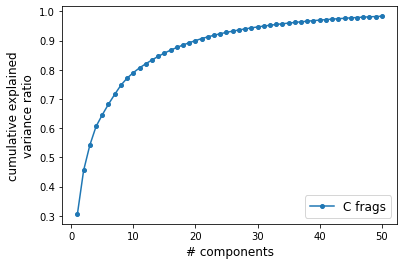

In [20]:
fig, ax = plt.subplots()

ax.plot(np.arange(cum_exp_var.shape[0])+1, cum_exp_var, marker='o', markersize=4, label='C frags')

ax.set_xlabel('# components', fontsize=12)
ax.set_ylabel('cumulative explained\nvariance ratio', fontsize=12)

ax.legend(loc='lower right', fontsize=12)

ax.set_facecolor('w')

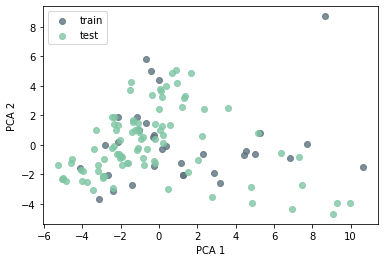

In [21]:
fig, ax = plt.subplots()

train_red = X_red[:33, :]
test_red  = X_red[33:, :]

ax.scatter(train_red[:, 0], train_red[:, 1], c='#5D737E', label='train', alpha=0.8)
ax.scatter(test_red[:, 0], test_red[:, 1], c='#7fc6a4', label='test', alpha=0.8)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')

ax.legend()

## Make batch of recommendations with Gryffin

In [ ]:
# make the gryffin observations

In [ ]:
# Gryffin config

# generate descriptors

config = {
     "general": {
             "backend": 'tensorflow',
             "num_cpus": 4,
             "auto_desc_gen": True, # dynamic Gryffin
             "batches": 1,
             "sampling_strategies": 40,
             "feas_approach": 'fca',
             "feas_param": 0.5,
             "boosted":  True,
             "caching": False,
             "random_seed": 22031996,
             "acquisition_optimizer": 'genetic',
             "verbosity": 3
                },
    "parameters": [
        {"name": "frag_c", "type": "categorical", "category_details": FRAG_C_DESC },
      
    ],
    "objectives": [
        {"name": "obj", "goal": "max"},
    ]
}

## Train NGBoost on the data

In [31]:
# do cross validation

indices = np.arange(33)
np.random.shuffle(indices)
work_x = X_red[:33, :]
work_y = np.log(np.array(targets))

num_folds = 4
fold_size = 8

folds = []

for num_fold in range(num_folds):
    
    fold_train_x = work_x[indices[fold_size:], :]
    fold_train_y = work_y[indices[fold_size:]]
    
    fold_test_x = work_x[indices[:fold_size], :]
    fold_test_y = work_y[indices[:fold_size]]
    
    
    folds.append({
        'train_x': fold_train_x,
        'train_y': fold_train_y,
        'test_x': fold_test_x,
        'test_y': fold_test_y,
    })
    
    indices = np.roll(indices, fold_size)

In [37]:
# cross validation models
for fold in folds:
    
    # create model 
    model = NGBRegressor(
            n_estimators=4000,
            random_state=42,
            learning_rate=0.001,
            tol=1e-4
    )
    
    model.fit(
        fold['train_x'],
        fold['train_y'],
    )
    
    # train set 
    pred_dists_train = model.pred_dist(fold['train_x'])
    pred_loc_train = pred_dists_train.loc
    pred_std_train = np.sqrt(pred_dists_train.var)
    
    # test set
    pred_dists_test = model.pred_dist(fold['test_x'])
    pred_loc_test = pred_dists_test.loc
    pred_std_test = np.sqrt(pred_dists_test.var)
    
    
    fold['pred_loc_train'] = pred_loc_train
    fold['pred_std_train'] = pred_std_train
    fold['pred_loc_test'] = pred_loc_test
    fold['pred_std_test'] = pred_std_test
    
    

[iter 0] loss=1.3979 val_loss=0.0000 scale=1.0000 norm=0.9882
[iter 100] loss=1.2100 val_loss=0.0000 scale=1.0000 norm=0.8360
[iter 200] loss=1.1080 val_loss=0.0000 scale=1.0000 norm=0.7675
[iter 300] loss=0.9883 val_loss=0.0000 scale=2.0000 norm=1.3866
[iter 400] loss=0.8724 val_loss=0.0000 scale=2.0000 norm=1.2649
[iter 500] loss=0.7664 val_loss=0.0000 scale=2.0000 norm=1.1785
[iter 600] loss=0.6689 val_loss=0.0000 scale=2.0000 norm=1.1176
[iter 700] loss=0.5690 val_loss=0.0000 scale=2.0000 norm=1.0699
[iter 800] loss=0.4704 val_loss=0.0000 scale=2.0000 norm=1.0359
[iter 900] loss=0.3723 val_loss=0.0000 scale=2.0000 norm=1.0117
[iter 1000] loss=0.2742 val_loss=0.0000 scale=2.0000 norm=0.9957
[iter 1100] loss=0.1765 val_loss=0.0000 scale=2.0000 norm=0.9848
[iter 1200] loss=0.0787 val_loss=0.0000 scale=2.0000 norm=0.9777
[iter 1300] loss=-0.0190 val_loss=0.0000 scale=2.0000 norm=0.9736
[iter 1400] loss=-0.1168 val_loss=0.0000 scale=2.0000 norm=0.9714
[iter 1500] loss=-0.2145 val_loss=0

[iter 600] loss=0.9090 val_loss=0.0000 scale=2.0000 norm=1.2527
[iter 700] loss=0.8104 val_loss=0.0000 scale=2.0000 norm=1.1731
[iter 800] loss=0.7070 val_loss=0.0000 scale=2.0000 norm=1.1048
[iter 900] loss=0.6056 val_loss=0.0000 scale=2.0000 norm=1.0570
[iter 1000] loss=0.5070 val_loss=0.0000 scale=2.0000 norm=1.0251
[iter 1100] loss=0.4078 val_loss=0.0000 scale=2.0000 norm=1.0041
[iter 1200] loss=0.3087 val_loss=0.0000 scale=2.0000 norm=0.9907
[iter 1300] loss=0.2095 val_loss=0.0000 scale=2.0000 norm=0.9828
[iter 1400] loss=0.1102 val_loss=0.0000 scale=2.0000 norm=0.9787
[iter 1500] loss=0.0110 val_loss=0.0000 scale=2.0000 norm=0.9770
[iter 1600] loss=-0.0882 val_loss=0.0000 scale=2.0000 norm=0.9770
[iter 1700] loss=-0.1875 val_loss=0.0000 scale=2.0000 norm=0.9779
[iter 1800] loss=-0.2870 val_loss=0.0000 scale=2.0000 norm=0.9795
[iter 1900] loss=-0.3864 val_loss=0.0000 scale=2.0000 norm=0.9813
[iter 2000] loss=-0.4860 val_loss=0.0000 scale=2.0000 norm=0.9832
[iter 2100] loss=-0.5856

fold 0 pear 0.008179060785194356 mae 1.0822049469568622 
fold 1 pear 0.11782291188757028 mae 1.18230045835005 
fold 2 pear -0.2750548528010815 mae 1.2566750713370824 
fold 3 pear -0.28359860512762425 mae 0.6896704703161411 


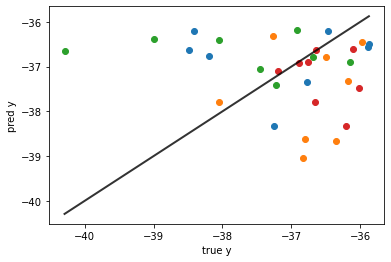

In [38]:
fig, ax = plt.subplots()

for ix, fold in enumerate(folds):
#     mape = mean_absolute_percentage_error(fold['test_y'], fold['pred_loc_test'])
    mae  = mean_absolute_error(fold['test_y'], fold['pred_loc_test'])
    pear = pearsonr(fold['test_y'], fold['pred_loc_test'])[0]
    ax.scatter(fold['test_y'], fold['pred_loc_test'])
    
    print(f'fold {ix} pear {pear} mae {mae} ')
    
ax.set_ylabel('pred y')
ax.set_xlabel('true y')

# ax.set_xscale('log')
# ax.set_yscale('log')

min_, max_ = np.amin(work_y), np.amax(work_y)

ax.plot([min_, max_], [min_, max_], c='k', lw=2, alpha=0.8)

## Train GP on the data

In [30]:
import torch
import gpytorch
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [31]:
class RBFKernelModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(RBFKernelModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
class MaternKernelModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MaternKernelModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    

In [32]:
# helper functions
def train_model(model, likelihood, train_x, train_y, training_iter=20):

    model.train()
    likelihood.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)  
    
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        if i % 100 == 0:
            print(f'Iter : {i+1}/{training_iter} - Loss : {loss.item()}')
        optimizer.step()
        
    return model, likelihood

def predict_model(model, likelihood, test_x):
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))
        
    return observed_pred

In [33]:
def forward_standardize(data, means, stds):
    ''' forward standardize the data
    '''
    return (data - means) / stds

def reverse_standardize(data, means, stds):
    ''' un-standardize the data
    '''
    return (data*stds) + means

def forward_normalize(data, min_, max_):
    ''' forward normalize the data
    '''
    ixs = np.where(np.abs(max_-min_)<1e-10)[0]
    if not ixs.size == 0:
        max_[ixs]=np.ones_like(ixs)
        min_[ixs]=np.zeros_like(ixs)
    return (data - min_) / (max_ - min_)

def reverse_normalize(data, min_, max_):
    ''' un-normlaize the data
    '''
    ixs = np.where(np.abs(max_-min_)<1e-10)[0]
    if not ixs.size == 0:
        max_[ixs]=np.ones_like(ixs)
        min_[ixs]=np.zeros_like(ixs)
    return data * (max_ - min_) + min_

In [47]:
# do cross validation

indices = np.arange(33)
np.random.shuffle(indices)
work_x = X_red[:33, :]
work_y = np.log(np.array(targets))

num_folds = 4
fold_size = 8

folds = []

for num_fold in range(num_folds):
    
    fold_train_x = work_x[indices[fold_size:], :]
    fold_train_y = work_y[indices[fold_size:]]
    
    fold_test_x = work_x[indices[:fold_size], :]
    fold_test_y = work_y[indices[:fold_size]]
    
    
    folds.append({
        'train_x': fold_train_x,
        'train_y': fold_train_y,
        'test_x': fold_test_x,
        'test_y': fold_test_y,
    })
    
    indices = np.roll(indices, fold_size)

In [48]:

# train and predict on all the folds
for fold in folds: 
    train_x = fold['train_x']
    print(train_x)
    _mins_x, _maxs_x = np.amin(train_x, axis=0), np.amax(train_x, axis=0)
    train_x_scal = torch.tensor(
        forward_normalize(train_x, _mins_x, _maxs_x)
    )
    
    
    train_y = fold['train_y']
    _mean_y, _std_y = np.mean(train_y), np.std(train_y)
    train_y_scal = torch.tensor(
        forward_standardize(train_y, _mean_y, _std_y)
    )
    
    test_x = fold['test_x']
    test_x_scal = torch.tensor(
        forward_normalize(test_x, _mins_x, _maxs_x)
    )
    
    test_y = fold['test_y']
    test_y_scal = torch.tensor(
        forward_standardize(test_y, _mean_y, _std_y)
    )
    
    mat_likelihood = gpytorch.likelihoods.GaussianLikelihood()
    mat_model = RBFKernelModel(train_x_scal, train_y_scal, mat_likelihood)
    #mat_model = MaternKernelModel(train_x_scal, train_y_scal, mat_likelihood)
    
    mat_model, mat_likelihood = train_model(
        mat_model, mat_likelihood, train_x_scal, train_y_scal, training_iter=100
    )

    mat_pred = predict_model(mat_model, mat_likelihood, train_x_scal)
    mat_mean_scal, mat_std = mat_pred.mean.detach().numpy(), torch.sqrt(mat_pred.variance).detach().numpy()
    mat_mean = reverse_standardize(mat_mean_scal, _mean_y, _std_y )
    
    mat_pred_test = predict_model(mat_model, mat_likelihood, test_x_scal)
    mat_mean_test_scal, mat_std_test = mat_pred_test.mean.detach().numpy(), torch.sqrt(mat_pred_test.variance).detach().numpy()
    mat_mean_test = reverse_standardize(mat_mean_test_scal, _mean_y, _std_y )
    
    fold['mat_mean'] = mat_mean
    fold['mat_std'] = mat_std
    fold['mat_mean_test'] = mat_mean_test
    fold['mat_std_test'] = mat_std_test
    
    

    
    

[[-1.14402917e+00  1.91134999e+00 -1.04623439e+00 ... -2.41822386e-01
  -1.54773625e-01 -1.16962391e-01]
 [-2.15294712e+00  1.86184268e+00 -1.09175729e+00 ...  3.34344932e-01
  -4.62097479e-01 -1.86580805e-01]
 [-1.02828755e+00  1.03753921e+00 -1.14967812e+00 ... -1.07339279e-02
  -1.82467782e-01 -9.10411088e-02]
 ...
 [-1.42236163e+00 -2.70939836e+00 -9.44852669e-01 ... -6.36533281e-03
   9.79411479e-03  1.49521165e-01]
 [ 7.73699742e+00  4.83399295e-02  1.95177923e+00 ...  2.24294609e-02
  -1.11780541e-01  6.50105309e-02]
 [ 1.06209922e+01 -1.49175044e+00  6.47498624e-01 ... -1.39006608e-01
  -3.10739758e-01  2.20727674e-01]]
Iter : 1/100 - Loss : 1.4435413330355322
[[-2.68515895e-01 -1.45329611e+00  4.41762314e+00 ...  1.46376573e-01
   5.43611622e-01 -2.78907431e-01]
 [-6.85731489e-01  1.49335455e+00  4.76151091e+00 ... -5.18206292e-02
  -1.41988995e-01 -1.86906242e-01]
 [-2.40989151e+00 -3.12209285e+00 -8.96244669e-01 ...  2.61927619e-02
   1.47607318e-01 -4.43343200e-04]
 ...
 [ 

/home/riley/Software/anaconda3/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


[[ 2.29099235 -0.6508815   1.34551611 ... -0.02052539 -0.03018385
  -0.17953917]
 [-0.28364803  0.67371355  4.49951468 ...  0.03774066 -0.23858087
  -0.04196005]
 [-2.67471787 -2.05188472 -0.97439928 ... -0.10851176 -0.03358273
  -0.13247507]
 ...
 [ 5.26070696  0.82987672  2.46021879 ...  0.11915127 -0.03485462
  -0.14261764]
 [ 4.99251531 -0.61332784  3.57895178 ...  0.26292751  0.1399743
  -0.36462338]
 [ 1.26925659 -2.05970558  1.60049947 ... -0.32200201 -0.01834342
  -0.323717  ]]
Iter : 1/100 - Loss : 1.4559035964659615
[[ 3.69418397e-01 -8.39813241e-02  2.87019111e+00 ...  1.73081786e-01
  -5.97698057e-02  4.47654646e-01]
 [-4.10050275e+00 -1.54885334e+00 -2.43834912e-01 ...  3.48339014e-02
   1.38055228e-01 -2.25480219e-03]
 [-3.26424014e-01  5.00400316e-01  2.50833230e+00 ... -3.89348211e-01
  -1.70532271e-01 -7.08876405e-02]
 ...
 [-2.13172269e+00  2.08691678e-01 -5.19027024e-01 ...  4.50882791e-02
   5.77111962e-02 -2.03283963e-01]
 [ 1.23837564e+00 -2.03438379e+00  1.649139

fold 0 pear -0.04761429937040501 mae 0.7715168672949488 mape 0.021138340954152755
fold 1 pear 0.47376112700602635 mae 0.4864481824328477 mape 0.013398435674076285
fold 2 pear -0.23833675979612162 mae 0.8532791514401783 mape 0.02218764870768218
fold 3 pear -0.2531283921991798 mae 1.0932698011326325 mape 0.028751390282823728


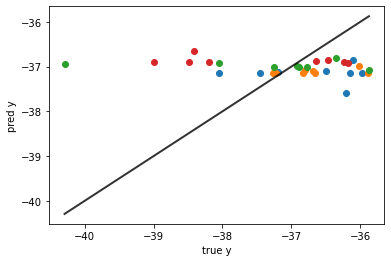

In [50]:
fig, ax = plt.subplots()

for ix, fold in enumerate(folds):
    mape = mean_absolute_percentage_error(fold['test_y'], fold['mat_mean_test'])
    mae  = mean_absolute_error(fold['test_y'], fold['mat_mean_test'])
    pear = pearsonr(fold['test_y'], fold['mat_mean_test'])[0]
    ax.scatter(fold['test_y'], fold['mat_mean_test'])
    
    print(f'fold {ix} pear {pear} mae {mae} mape {mape}')
    
ax.set_ylabel('pred y')
ax.set_xlabel('true y')

# ax.set_xscale('log')
# ax.set_yscale('log')

min_, max_ = np.amin(work_y), np.amax(work_y)

ax.plot([min_, max_], [min_, max_], c='k', lw=2, alpha=0.8)

## train the GP on the entire training set and make prediction on heldout set

In [51]:
train_x = torch.tensor(X_red[:33, :])
train_y = np.array(np.log10(targets))
_mean_y, _std_y = np.mean(train_y), np.std(train_y)
train_y_scal_np = forward_standardize(train_y, _mean_y, _std_y)
train_y_scal = torch.tensor(train_y_scal_np)


test_x = torch.tensor(X_red[33:, :])

print(train_x.shape, train_y.shape, test_x.shape)

torch.Size([33, 50]) (33,) torch.Size([93, 50])


In [52]:
mat_likelihood = gpytorch.likelihoods.GaussianLikelihood()
mat_model = MaternKernelModel(train_x, train_y_scal, mat_likelihood)

In [53]:
mat_model, mat_likelihood = train_model(mat_model, mat_likelihood, train_x, train_y_scal, training_iter=500)

mat_pred = predict_model(mat_model, mat_likelihood, test_x)
mat_mean_scal, mat_std = mat_pred.mean.detach().numpy(), torch.sqrt(mat_pred.variance).detach().numpy()

#mat_mean = reverse_standardize(mat_mean_scal, _mean_y, _std_y )

Iter : 1/500 - Loss : 1.4479821670552717
Iter : 101/500 - Loss : 1.422187793275986
Iter : 201/500 - Loss : 1.4198143511815704
Iter : 301/500 - Loss : 1.4192682198765163
Iter : 401/500 - Loss : 1.4190961023970208


/home/riley/Software/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

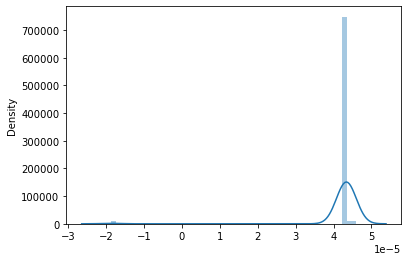

In [54]:
# visualize the test set predictions
fig, ax = plt.subplots()
sns.distplot(mat_mean_scal, ax=ax)
#sns.distplot(train_y_scal_np, ax=ax)

In [ ]:
#sns.histplot(train_y)
sns.rugplot(train_y)
plt.xscale('log')

<AxesSubplot:>

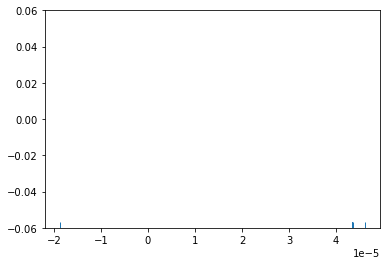

In [55]:
sns.rugplot(mat_mean_scal)

## Visualize the structures of the training and test sets

In [ ]:
frag_c_smiles

In [ ]:
unmeas_frag_c_smiles

In [ ]:
smi = frag_c_smiles[0]
mol = chem.MolFromSmiles(smi)

In [ ]:
mod_mol = chem.ReplaceSubstructs(
            mol,
            chem.MolFromSmiles('Br'),
            chem.MolFromSmiles('C=C'),
            replaceAll=True,
        )[0]

In [ ]:
mol

In [ ]:
mod_mol